In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import random

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

from sklearn.utils import resample                      # Fare splitting
from sklearn.model_selection import validation_curve

# CLASSIFICAZIONE *RIADMISSION IN 30 DAYS*

In [2]:
### nota: la dicitura *r30* sta per riadmission in 30 days

In [3]:
df1 = pd.read_csv("df1.csv")

dato che bisogna predire la riammissione entro 30 giorni, vado ad eliminare tutte le feature riguardanti
riammissioni e e il campo della morte

In [4]:
remove_for_r30 = [
'death',
'riad 90d',
'riad 365d', 
'riad +365d',
]

In [5]:
remove_for_r30

['death', 'riad 90d', 'riad 365d', 'riad +365d']

In [6]:
df1.drop(remove_for_r30, axis=1, inplace=True)

In [7]:
df1

,gender,age,riad 30d,icd_D_blood,icd_D_health_status,icd_D_pregnancy,icd_D_abnormal,icd_D_chromosomal,icd_D_infectious_parasitic,icd_D_musculoskeletal,...,ethn__BLACK/AFRICAN AMERICAN,ethn__HISPANIC/LATINO,ethn__OTHER,ethn__UNKNOWN,ethn__WHITE,ins__Medicare,ins__Other,maritalS__MARRIED,maritalS__SINGLE,maritalS__WIDOWED
0,1,0,0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,1,0,0
1,0,52,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,1,0,1,0,0,1
2,0,52,1,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,1
3,0,52,1,0.0,3.0,0.0,2.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,1
4,0,52,0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521105,0,46,0,1.0,4.0,0.0,0.0,0.0,1.0,2.0,...,0,0,0,0,1,0,1,0,1,0
521106,0,48,0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,1,0,1,0,1,0
521107,1,58,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,0,1
521108,1,58,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,0,1


## creo training set, validation set, test set

In [8]:
train, validate, test = np.split(df1.sample(frac=1, random_state=42), [int(.6*len(df1)), int(.7*len(df1))])

## separo le label dai predittori

In [9]:
X_train_r30 = train.drop(["riad 30d"], axis=1)

In [10]:
y_train_r30 = train["riad 30d"]

In [11]:
X_validate_r30 = validate.drop(["riad 30d"], axis=1)

In [12]:
y_validate_r30 = validate["riad 30d"]

In [13]:
X_test_r30 = test.drop(["riad 30d"], axis=1)

In [14]:
y_test_r30 = test["riad 30d"]

controllo che la stratificazione in base alla label sia andata a buon fine:

In [15]:
# proporzione di classi positive (death 1) nel training set
tot_pos_train = len(y_train_r30[y_train_r30 == 1])
prop_pos_train = tot_pos_train / len(y_train_r30) * 100

print('{} % di riammessi entro 30 giorni nel training set'.format(prop_pos_train))
print('{} % di non riammessi entro 30 giorni nel training set'.format(100 - prop_pos_train))

print()

# proporzione di classi negative (death 0) nel validate set
tot_pos_validate = len(y_validate_r30[y_validate_r30 == 1])
prop_pos_validate = tot_pos_validate / len(y_validate_r30) * 100

print('{} % di riammessi entro 30 giorni nel validate set'.format(prop_pos_validate))
print('{} % non di riammessi entro 30 giorni nel validate set'.format(100 - prop_pos_validate))

print()

# proporzione di classi negative (death 0) nel testing set
tot_pos_test = len(y_test_r30[y_test_r30 == 1])
prop_pos_test = tot_pos_test / len(y_test_r30) * 100

print('{} % di riammessi entro 30 giorni ospedaliere nel testing set'.format(prop_pos_test))
print('{} % di non riammessi entro 30 giorni nel testing set'.format(100 - prop_pos_test))

17.987245175362848 % di riammessi entro 30 giorni nel training set
82.01275482463716 % di non riammessi entro 30 giorni nel training set

17.961658766863042 % di riammessi entro 30 giorni nel validate set
82.03834123313696 % non di riammessi entro 30 giorni nel validate set

18.331382369685222 % di riammessi entro 30 giorni ospedaliere nel testing set
81.66861763031477 % di non riammessi entro 30 giorni nel testing set


### standardizzo le features che hanno diverse scale di valori

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_r30_scaled = scaler.fit_transform(X_train_r30)  # fitting and transforming training set
X_train_r30_scaled

array([[-0.96512577, -0.75686884,  0.96630854, ..., -0.87579316,
         1.20438887, -0.32124958],
       [-0.96512577,  0.69621419, -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958],
       [ 1.03613439,  1.04036543, -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       ...,
       [-0.96512577, -0.5656737 , -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       [ 1.03613439,  0.35206295, -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       [-0.96512577, -1.17749813,  2.44962278, ..., -0.87579316,
         1.20438887, -0.32124958]])

## Modelli di classificazione

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [18]:
models = [SGDClassifier, DecisionTreeClassifier, RandomForestClassifier, LogisticRegression]
names = ['SGD Classifier', 'Decision Tree Classifier', 'RandomForestClassifier', 'Logistic Regressor']

In [19]:
from sklearn.metrics import accuracy_score

for i in range(len(models)):
    model = models[i](random_state=42)  # inizializzo il modello qui (non ancora addestrato)
    name = names[i] 
    model.fit(X_train_r30_scaled, y_train_r30) # qui addestro il modello sui dati
    y_pred_r30 = model.predict(X_train_r30_scaled)
    print(f'accuracy of {name}: ',accuracy_score(y_pred_r30, y_train_r30))

accuracy of SGD Classifier:  0.8201083584399966
accuracy of Decision Tree Classifier:  0.9941439107546072
accuracy of RandomForestClassifier:  0.9941343158514198
accuracy of Logistic Regressor:  0.8191360749170041


anche nella predizione delle riammissioni entro 30 giorni otteniamo apparentemente delle prestazioni elevate ma siamo sempre di fronte  aun dataset sbilanciato

## cross validation

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score


names_cv = ['sgd_cv', 'dt_cv', 'rf_cv', 'lr_cv']

for i in range(len(models)):
    avg_acc_models = []
    model = models[i](random_state=42)  # inizializzo il modello qui (non ancora addestrato)
    name = names[i] 
    acc_model = cross_val_score(model, X_train_r30_scaled, y_train_r30, cv=3, scoring='accuracy')
    avg_acc_model = acc_model.mean()
    avg_acc_models.append(avg_acc_model)
    print(f'accuracy of {name}: ', avg_acc_model)

accuracy of SGD Classifier:  0.8199868229996227
accuracy of Decision Tree Classifier:  0.7364471992477597
accuracy of RandomForestClassifier:  0.8204473783526192
accuracy of Logistic Regressor:  0.8191168851106291


## analisi sui singoli modelli: SGD, DT, RF, LR
procedo ad analizzarli uno per uno esaminando le predizioni fatte tramite cross validation\
questa volta utilizzo *5-fold cross validation* per ogni modello

In [21]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

### analisi specifica su SGD Classifier

In [22]:
sgd_cv = SGDClassifier(random_state=42)
y_pred_sgd_cv = cross_val_predict(sgd_cv, X_train_r30_scaled, y_train_r30, cv=5)
score_sgd_cv = accuracy_score(y_train_r30, y_pred_sgd_cv)

In [23]:
list(y_pred_sgd_cv).count(1)  # numero di predizioni di riammissioni entro 30 giorni

629

In [24]:
score_sgd_cv

0.8198301062475613

### confusion matrix SGD

In [25]:
cm_r30_sgd = confusion_matrix(y_train_r30, y_pred_sgd_cv)
cm_r30_sgd

array([[256065,    361],
       [ 55972,    268]], dtype=int64)

In [26]:
print("PREDIZIONI STOCHASTIC GRADIENT DESCENT CON CROSS VALIDATION")
print("{} veri positivi".format(cm_r30_sgd[1,1]))
print("{} veri negativi".format(cm_r30_sgd[0,0]))
print("{} falsi positivi".format(cm_r30_sgd[0,1]))
print("{} falsi negativi".format(cm_r30_sgd[1,0]))

PREDIZIONI STOCHASTIC GRADIENT DESCENT CON CROSS VALIDATION
268 veri positivi
256065 veri negativi
361 falsi positivi
55972 falsi negativi


In [27]:
ps_sgd = precision_score(y_train_r30, y_pred_sgd_cv)
rs_sgd = recall_score(y_train_r30, y_pred_sgd_cv)
f1_sgd = f1_score(y_train_r30, y_pred_sgd_cv)

### analisi più specifica sul Random Forest Classifier

In [28]:
 rf_cv = RandomForestClassifier(random_state=42)
 y_pred_rf_cv = cross_val_predict(rf_cv, X_train_r30_scaled, y_train_r30, cv=5)
 score_rf_cv = accuracy_score(y_train_r30, y_pred_rf_cv)

In [29]:
 list(y_pred_rf_cv).count(1)  # numero di predizioni di morti ospedaliere

8936

In [30]:
 score_rf_cv

0.8206328798142427

### confusion matrix RF

In [31]:
 cm_r30_rf = confusion_matrix(y_train_r30, y_pred_rf_cv)
 cm_r30_rf

array([[252037,   4389],
       [ 51693,   4547]], dtype=int64)

In [32]:
 print("PREDIZIONI RANDOM FOREST CLASSIFIER CON CROSS VALIDATION")
 print("{} veri positivi".format(cm_r30_rf[1,1]))
 print("{} veri negativi".format(cm_r30_rf[0,0]))
 print("{} falsi positivi".format(cm_r30_rf[0,1]))
 print("{} falsi negativi".format(cm_r30_rf[1,0]))

PREDIZIONI RANDOM FOREST CLASSIFIER CON CROSS VALIDATION
4547 veri positivi
252037 veri negativi
4389 falsi positivi
51693 falsi negativi


In [33]:
ps_rf = precision_score(y_train_r30, y_pred_rf_cv)
rs_rf = recall_score(y_train_r30, y_pred_rf_cv)
f1_rf = f1_score(y_train_r30, y_pred_rf_cv)

Rispetto al Stochastic gradient Descent, il Random Forest predice piu riammissioni, ma comunque
molto poche

### analisi più specifica sul Logistic Regressor

In [34]:
lr_cv = LogisticRegression(random_state=42)
y_pred_lr_cv = cross_val_predict(lr_cv, X_train_r30_scaled, y_train_r30, cv=5)
score_lr_cv = accuracy_score(y_train_r30, y_pred_lr_cv)

In [35]:
list(y_pred_lr_cv).count(1)  # numero di predizioni di morti ospedaliere

3424

In [36]:
score_lr_cv

0.81901453947663

### confusion matrix LR

In [37]:
cm_r30_lr = confusion_matrix(y_train_r30, y_pred_lr_cv)
cm_r30_lr

array([[254540,   1886],
       [ 54702,   1538]], dtype=int64)

In [38]:
print("PREDIZIONI LOGISTIC REGRESSOR CON CROSS VALIDATION")
print("{} veri positivi".format(cm_r30_lr[1,1]))
print("{} veri negativi".format(cm_r30_lr[0,0]))
print("{} falsi positivi".format(cm_r30_lr[0,1]))
print("{} falsi negativi".format(cm_r30_lr[1,0]))

PREDIZIONI LOGISTIC REGRESSOR CON CROSS VALIDATION
1538 veri positivi
254540 veri negativi
1886 falsi positivi
54702 falsi negativi


In [39]:
ps_lr = precision_score(y_train_r30, y_pred_lr_cv)
rs_lr = recall_score(y_train_r30, y_pred_lr_cv)
f1_lr = f1_score(y_train_r30, y_pred_lr_cv)
print('precision score is {}'.format(ps_lr))
print('recall score is {}'.format(rs_lr))
print('f1 score is {}'.format(f1_lr))

precision score is 0.4491822429906542
recall score is 0.027347083926031295
f1 score is 0.051555376776615716


### precision, recall, f1 del Logistic Regressor

In [40]:
ps_lr = precision_score(y_train_r30, y_pred_lr_cv)
rs_lr = recall_score(y_train_r30, y_pred_lr_cv)
f1_lr = f1_score(y_train_r30, y_pred_lr_cv)
print('precision score is {}'.format(ps_lr))
print('recall score is {}'.format(rs_lr))
print('f1 score is {}'.format(f1_lr))

precision score is 0.4491822429906542
recall score is 0.027347083926031295
f1 score is 0.051555376776615716


### analisi più specifica sul Decision Tree

In [41]:
dt_cv = DecisionTreeClassifier(random_state=42)
y_pred_dt_cv = cross_val_predict(dt_cv, X_train_r30_scaled, y_train_r30, cv=5)
score_dt_cv = accuracy_score(y_train_r30, y_pred_dt_cv)

In [42]:
score_dt_cv

0.7363448536137603

### confusion matrix DT

In [43]:
cm_r30_dt = confusion_matrix(y_train_r30, y_pred_dt_cv)
cm_r30_dt

array([[213374,  43052],
       [ 39384,  16856]], dtype=int64)

In [44]:
print("PREDIZIONI DECISION TREE CON CROSS VALIDATION")
print("{} veri positivi".format(cm_r30_dt[1,1]))
print("{} veri negativi".format(cm_r30_dt[0,0]))
print("{} falsi positivi".format(cm_r30_dt[0,1]))
print("{} falsi negativi".format(cm_r30_dt[1,0]))

PREDIZIONI DECISION TREE CON CROSS VALIDATION
16856 veri positivi
213374 veri negativi
43052 falsi positivi
39384 falsi negativi


### precision, recall, f1 del Decision Tree

In [45]:
ps_dt = precision_score(y_train_r30, y_pred_dt_cv)
rs_dt = recall_score(y_train_r30, y_pred_dt_cv)
f1_dt = f1_score(y_train_r30, y_pred_dt_cv)
print('precision score is {}'.format(ps_dt))
print('recall score is {}'.format(rs_dt))
print('f1 score is {}'.format(f1_dt))

precision score is 0.28136475929758964
recall score is 0.2997155049786629
f1 score is 0.290250370217309


# Commenti post crossvalidation

il dataset è sempre sbilanciato e i valori di precision, recall e f1 score sono sempre molto bassi, effettuiamo nuovamente l'oversampling per vedere se aumentano anche in questo caso

## OVERSAMPLING

In [46]:
from imblearn.over_sampling import SMOTE

In [47]:
eq = SMOTE()
X_train_r30_ov, y_train_r30_ov = eq.fit_resample(X_train_r30_scaled, y_train_r30.ravel())  # reshape 1D flatten

### risultati oversampling

In [48]:
len(X_train_r30_ov)  # nuova lunghezza del dataset

512852

In [49]:
list(y_train_r30).count(1) # numero di morti ospedaliere PRIMA dell'oversampling

56240

In [50]:
list(y_train_r30_ov).count(1) # numero di morti ospedaliere DOPO l'oversampling

256426

In [51]:
list(y_train_r30).count(0) # numero di sopravvissuti PRIMA dell'oversampling

256426

In [52]:
list(y_train_r30_ov).count(0) # numero di sopravvissuti DOPO l'oversampling

256426

## Nuove Predizioni POST oversampling

### Decision Tree

In [53]:
dt = DecisionTreeClassifier(random_state=42)

In [54]:
y_pred_dt_cv_ov = cross_val_predict(dt, X_train_r30_ov, y_train_r30_ov, cv=3)
score_dt_ov = accuracy_score(y_train_r30_ov, y_pred_dt_cv_ov)

In [55]:
score_dt_ov

0.8141471613642922

In [56]:
cm_dt_ov = confusion_matrix(y_train_r30_ov, y_pred_dt_cv_ov)
ps_dt_ov = precision_score(y_train_r30_ov, y_pred_dt_cv_ov)
rs_dt_ov = recall_score(y_train_r30_ov, y_pred_dt_cv_ov)
f1_dt_ov = f1_score(y_train_r30_ov, y_pred_dt_cv_ov)

In [57]:
perf_dt = {'Metric': ['precision','recall','f1'],
        'pre-oversampling': [ps_dt,rs_dt,f1_dt],
        'post-oversampling': [ps_dt_ov, rs_dt_ov, f1_dt_ov]
        }

In [58]:
table_dt = pd.DataFrame(perf_dt, columns = ['Metric', 'pre-oversampling', 'post-oversampling'])
table_dt.style.set_table_attributes("style='display:inline'").set_caption('DECISION TREE PERFORMANCES')

,Metric,pre-oversampling,post-oversampling
0,precision,0.281365,0.832131
1,recall,0.299716,0.787073
2,f1,0.290250,0.808975


### Logistic Regressor

In [59]:
lr = LogisticRegression(random_state=42)

In [60]:
y_pred_lr_cv_ov = cross_val_predict(lr, X_train_r30_ov, y_train_r30_ov, cv=3)
score_lr_ov = accuracy_score(y_train_r30_ov, y_pred_lr_cv_ov)

In [61]:
score_lr_ov

0.6478516219104147

In [62]:
cm_lr_ov = confusion_matrix(y_train_r30_ov, y_pred_lr_cv_ov)
ps_lr_ov = precision_score(y_train_r30_ov, y_pred_lr_cv_ov)
rs_lr_ov = recall_score(y_train_r30_ov, y_pred_lr_cv_ov)
f1_lr_ov = f1_score(y_train_r30_ov, y_pred_lr_cv_ov)

In [63]:
perf_lr = {'Metric': ['precision','recall','f1'],
        'pre-oversampling': [ps_lr,rs_lr,f1_lr],
        'post-oversampling': [ps_lr_ov, rs_lr_ov, f1_lr_ov]
        }

In [64]:
table_lr = pd.DataFrame(perf_lr, columns = ['Metric', 'pre-oversampling', 'post-oversampling'])
table_lr.style.set_table_attributes("style='display:inline'").set_caption('LOGISTIC REGRESSION PERFORMANCES')

,Metric,pre-oversampling,post-oversampling
0,precision,0.449182,0.627859
1,recall,0.027347,0.726034
2,f1,0.051555,0.673387


### Random Forest

In [65]:
rf = RandomForestClassifier(random_state=42)

In [66]:
y_pred_rf_cv_ov = cross_val_predict(rf, X_train_r30_ov, y_train_r30_ov, cv=3)
score_rf_ov = accuracy_score(y_train_r30_ov, y_pred_rf_cv_ov)

In [67]:
score_rf_ov

0.8731992855638664

In [68]:
cm_rf_ov = confusion_matrix(y_train_r30_ov, y_pred_rf_cv_ov)
ps_rf_ov = precision_score(y_train_r30_ov, y_pred_rf_cv_ov)
rs_rf_ov = recall_score(y_train_r30_ov, y_pred_rf_cv_ov)
f1_rf_ov = f1_score(y_train_r30_ov, y_pred_rf_cv_ov)

In [69]:
perf_rf = {'Metric': ['precision','recall','f1'],
        'pre-oversampling': [ps_rf,rs_rf,f1_rf],
        'post-oversampling': [ps_rf_ov, rs_rf_ov, f1_rf_ov]
        }

In [70]:
table_rf = pd.DataFrame(perf_rf, columns = ['Metric', 'pre-oversampling', 'post-oversampling'])
table_rf.style.set_table_attributes("style='display:inline'").set_caption('RANDOM FOREST PERFORMANCES')

,Metric,pre-oversampling,post-oversampling
0,precision,0.508841,0.951730
1,recall,0.080850,0.786278
2,f1,0.139530,0.861128


# Considerazioni post oversampling
anche questa volta dopo l'oversampling si può notare un netto miglioramento almeno apparentemente dei valori di precision, recall e f1 score

## Predizioni sul validation set
andiamo nuovamente a verificare le prestazioni sul validation set

In [71]:
X_validate_r30  # il validation set mai visto dal modello, che bisogna però scalare

,gender,age,icd_D_blood,icd_D_health_status,icd_D_pregnancy,icd_D_abnormal,icd_D_chromosomal,icd_D_infectious_parasitic,icd_D_musculoskeletal,icd_D_nervous_system,...,ethn__BLACK/AFRICAN AMERICAN,ethn__HISPANIC/LATINO,ethn__OTHER,ethn__UNKNOWN,ethn__WHITE,ins__Medicare,ins__Other,maritalS__MARRIED,maritalS__SINGLE,maritalS__WIDOWED
300792,0,0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,1,0,0
274325,0,55,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,1,0,1,1,0,0
185779,0,63,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
117038,1,53,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,1,0,0
290892,0,29,1.0,5.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108278,1,39,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,1,0,0,0,1,0
127414,1,63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,1,0,0
196974,1,0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,1,0
245347,0,61,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,...,0,0,0,0,1,0,1,1,0,0


In [72]:
y_validate_r30  # questi sono i dati su cui verrà calcolato l'accuracy score finale

300792    0
274325    1
185779    0
117038    1
290892    0
         ..
108278    0
127414    0
196974    0
245347    0
465409    0
Name: riad 30d, Length: 52111, dtype: int64

In [73]:
X_validate_r30_scaled = scaler.transform(X_validate_r30)  # fitting and transforming validation set
X_validate_r30_scaled

array([[-0.96512577, -1.9805177 , -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       [-0.96512577,  0.12262879, -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       [-0.96512577,  0.428541  , -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958],
       ...,
       [ 1.03613439, -1.9805177 , -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958],
       [-0.96512577,  0.35206295, -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       [-0.96512577,  0.8491703 , -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958]])

### Random Forest

In [74]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_r30_ov, y_train_r30_ov)

RandomForestClassifier(random_state=42)

In [75]:
validation_pred_rf = rf.predict(X_validate_r30_scaled)
validation_pred_rf

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [76]:
acc_rf = accuracy_score(y_validate_r30, validation_pred_rf)
acc_rf

0.8165454510563989

In [77]:
cm_rf_validation = confusion_matrix(y_validate_r30, validation_pred_rf)
ps_rf_validation = precision_score(y_validate_r30, validation_pred_rf)
rs_rf_validation = recall_score(y_validate_r30, validation_pred_rf)
f1_rf_validation = f1_score(y_validate_r30, validation_pred_rf)

In [78]:
perf_rf_validation = {
           'Metric': ['precision','recall','f1'],
           'validation': [ps_rf_validation, rs_rf_validation, f1_rf_validation]
          }

In [79]:
table_rf_validation = pd.DataFrame(perf_rf_validation, columns = ['Metric', 'validation'])
table_rf_validation.style.set_table_attributes("style='display:inline'").set_caption('RANDOM FOREST VALIDATION PERFORMANCES')

,Metric,validation
0,precision,0.449444
1,recall,0.094979
2,f1,0.156818


In [80]:
print("{} veri positivi".format(cm_rf_validation[1,1]))
print("{} veri negativi".format(cm_rf_validation[0,0]))
print("{} falsi positivi".format(cm_rf_validation[0,1]))
print("{} falsi negativi".format(cm_rf_validation[1,0]))

889 veri positivi
41662 veri negativi
1089 falsi positivi
8471 falsi negativi


### Logistic Regressor

In [81]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_r30_ov, y_train_r30_ov)

LogisticRegression(random_state=42)

In [82]:
validation_pred_lr = lr.predict(X_validate_r30_scaled)
validation_pred_lr

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [83]:
acc_lr = accuracy_score(y_validate_r30, validation_pred_lr)
acc_lr

0.5956132102627084

In [84]:
cm_lr_validation = confusion_matrix(y_validate_r30, validation_pred_lr)
ps_lr_validation = precision_score(y_validate_r30, validation_pred_lr)
rs_lr_validation = recall_score(y_validate_r30, validation_pred_lr)
f1_lr_validation = f1_score(y_validate_r30, validation_pred_lr)

In [85]:
perf_lr_validation = {
                   'Metric': ['precision','recall','f1'],
                   'validation': [ps_lr_validation, rs_lr_validation, f1_lr_validation]
                 }

In [86]:
table_lr_validation = pd.DataFrame(perf_lr_validation, columns = ['Metric', 'validation'])
table_lr_validation.style.set_table_attributes("style='display:inline'").set_caption('LOGISTIC REGRESSOR VALIDATION PERFORMANCES')

,Metric,validation
0,precision,0.269855
1,recall,0.733654
2,f1,0.394576


In [87]:
print("{} veri positivi".format(cm_lr_validation[1,1]))
print("{} veri negativi".format(cm_lr_validation[0,0]))
print("{} falsi positivi".format(cm_lr_validation[0,1]))
print("{} falsi negativi".format(cm_lr_validation[1,0]))

6867 veri positivi
24171 veri negativi
18580 falsi positivi
2493 falsi negativi


### Decision Tree

In [88]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_r30_ov, y_train_r30_ov)

DecisionTreeClassifier(random_state=42)

In [89]:
validation_pred_dt = dt.predict(X_validate_r30_scaled)
validation_pred_dt

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [90]:
acc_dt = accuracy_score(y_validate_r30, validation_pred_dt)
acc_dt

0.7319951641687935

In [91]:
cm_dt_validation = confusion_matrix(y_validate_r30, validation_pred_dt)
ps_dt_validation = precision_score(y_validate_r30, validation_pred_dt)
rs_dt_validation = recall_score(y_validate_r30, validation_pred_dt)
f1_dt_validation = f1_score(y_validate_r30, validation_pred_dt)

In [92]:
perf_dt_validation = {
                   'Metric': ['precision','recall','f1'],
                   'validation': [ps_dt_validation, rs_dt_validation, f1_dt_validation]
                 }

In [93]:
table_dt_validation = pd.DataFrame(perf_dt_validation, columns = ['Metric', 'validation'])
table_dt_validation.style.set_table_attributes("style='display:inline'").set_caption('DECISION TREE VALIDATION PERFORMANCES')

,Metric,validation
0,precision,0.277057
1,recall,0.305769
2,f1,0.290706


In [94]:
print("{} veri positivi".format(cm_dt_validation[1,1]))
print("{} veri negativi".format(cm_dt_validation[0,0]))
print("{} falsi positivi".format(cm_dt_validation[0,1]))
print("{} falsi negativi".format(cm_dt_validation[1,0]))

2862 veri positivi
35283 veri negativi
7468 falsi positivi
6498 falsi negativi


# considerazioni post validation

il modello che pare essere più bilanciato tra precision e recall è decision tre mentre quello che in generale ha un f1 score maggiore il logistic regressor 

## HYPERPARAMETERS TUNING

vediamo se questa volta è possibile migliorare le predizioni con il tuning per la random forest e il logistic regressor

### Random Forest

#### tuning del n_estimators (default = 100)

In [95]:
num_est = [1, 10, 50, 100]

In [96]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train_r30_ov, y = y_train_r30_ov, 
                                param_name = 'n_estimators', 
                                param_range = num_est, cv = 3)

In [97]:
train_scoreNum

array([[0.96787667, 0.90917254, 0.90836848],
       [0.99618896, 0.98419718, 0.98398079],
       [0.99723019, 0.99407723, 0.99435218],
       [0.99727114, 0.99418253, 0.99446333]])

In [98]:
test_scoreNum

array([[0.68724371, 0.8492726 , 0.84457444],
       [0.68494481, 0.95140128, 0.95077508],
       [0.6851203 , 0.96460974, 0.96437555],
       [0.68514955, 0.96780949, 0.96705469]])

In [99]:
avg_train_scoreNum = np.average(train_scoreNum, axis=1)

In [100]:
avg_test_scoreNum = np.average(test_scoreNum, axis=1)

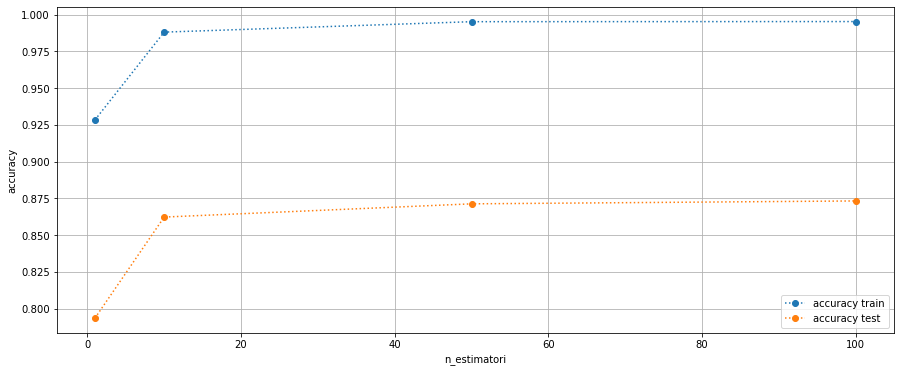

In [101]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(num_est,avg_train_scoreNum, 'o:', label='accuracy train')
ax.plot(num_est,avg_test_scoreNum, 'o:', label='accuracy test')
ax.set_ylabel('accuracy')
ax.set_xlabel('n_estimatori')
ax.grid()
ax.legend()

#### tuning max_depth (deault none)

In [102]:
max_depth = [1, 10, 25, 50, 100, 200]

In [103]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train_r30_ov, y = y_train_r30_ov, 
                                param_name = 'max_depth', 
                                param_range = max_depth, cv = 3)

In [104]:
train_scoreNum

array([[0.66306621, 0.61437375, 0.63586349],
       [0.93696713, 0.80346065, 0.80364256],
       [0.99016382, 0.96263538, 0.96245123],
       [0.99726822, 0.9941796 , 0.99446918],
       [0.99727406, 0.99418545, 0.99447503],
       [0.99727406, 0.9941796 , 0.99447503]])

In [105]:
test_scoreNum

array([[0.61352083, 0.62883516, 0.65532612],
       [0.67865061, 0.88885119, 0.8878327 ],
       [0.6842253 , 0.9651947 , 0.96487277],
       [0.68495651, 0.96777439, 0.9669728 ],
       [0.68469912, 0.96744681, 0.96734718],
       [0.68523144, 0.96790893, 0.96670956]])

In [106]:
avg_train_scoreNum = np.average(train_scoreNum, axis=1)

In [107]:
avg_test_scoreNum = np.average(test_scoreNum, axis=1)

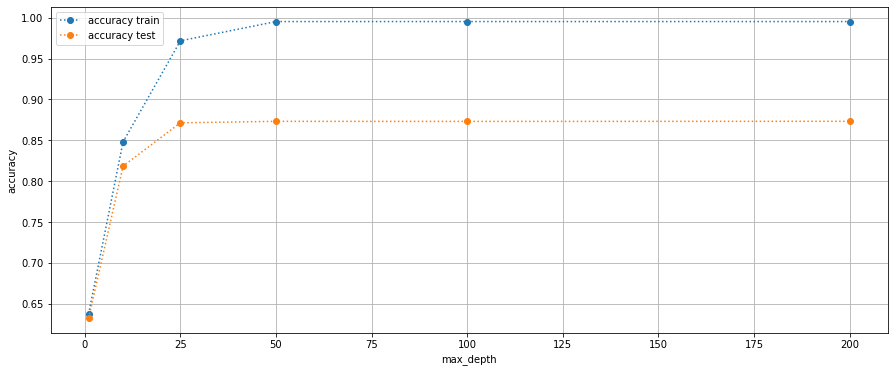

In [108]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(max_depth,avg_train_scoreNum, 'o:', label='accuracy train')
ax.plot(max_depth,avg_test_scoreNum, 'o:', label='accuracy test')
ax.set_ylabel('accuracy')
ax.set_xlabel('max_depth')
ax.grid()
ax.legend()

#### tuning min_samples_split (default = 2)

In [109]:
min_samples_split = [1, 2, 3, 4, 5]

In [110]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train_r30_ov, y = y_train_r30_ov, 
                                param_name = 'min_samples_split', 
                                param_range = min_samples_split, cv = 3)

In [111]:
train_scoreNum

array([[       nan,        nan,        nan],
       [0.99727699, 0.9941913 , 0.99447503],
       [0.99695233, 0.99255925, 0.99288393],
       [0.99608074, 0.9883592 , 0.98859615],
       [0.9954519 , 0.98303895, 0.9833812 ]])

In [112]:
test_scoreNum

array([[       nan,        nan,        nan],
       [0.6850267 , 0.96787384, 0.96713659],
       [0.68401472, 0.96793233, 0.96739397],
       [0.68369299, 0.96868693, 0.96808424],
       [0.6827161 , 0.96902621, 0.96860486]])

In [113]:
avg_train_scoreNum = np.average(train_scoreNum, axis=1)

In [114]:
avg_test_scoreNum = np.average(test_scoreNum, axis=1)

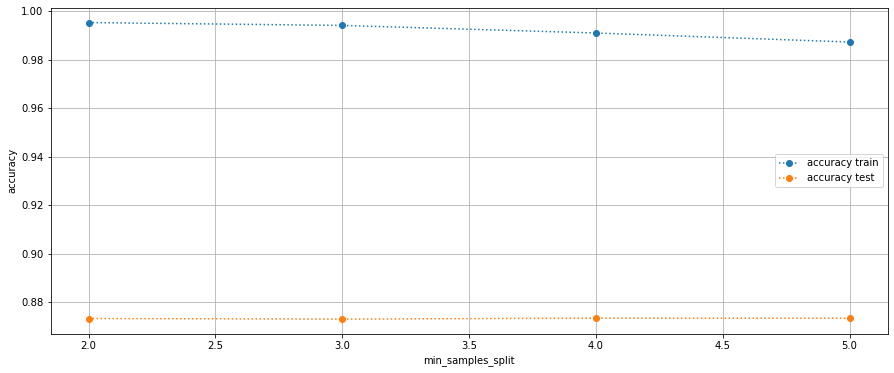

In [115]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(min_samples_split,avg_train_scoreNum, 'o:', label='accuracy train')
ax.plot(min_samples_split,avg_test_scoreNum, 'o:', label='accuracy test')
ax.set_ylabel('accuracy')
ax.set_xlabel('min_samples_split')
ax.grid()
ax.legend()

#### tuning min_samples_leaf (default = 1)

In [116]:
min_samples_leaf = [1, 2, 3, 4, 5]

In [117]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train_r30_ov, y = y_train_r30_ov, 
                                param_name = 'min_samples_leaf', 
                                param_range = min_samples_leaf, cv = 3)

In [118]:
train_scoreNum

array([[0.99727699, 0.99418545, 0.99447795],
       [0.99173152, 0.96214401, 0.96262379],
       [0.98874236, 0.93351584, 0.93344584],
       [0.98697576, 0.91460686, 0.91462173],
       [0.98563327, 0.9015095 , 0.90183737]])

In [119]:
test_scoreNum

array([[0.68511445, 0.96761645, 0.96706054],
       [0.68225398, 0.96786799, 0.96688505],
       [0.68094366, 0.96594346, 0.96582626],
       [0.67993168, 0.96379664, 0.96411231],
       [0.6794988 , 0.96316488, 0.96269085]])

In [120]:
avg_train_scoreNum = np.average(train_scoreNum, axis=1)

In [121]:
avg_test_scoreNum = np.average(test_scoreNum, axis=1)

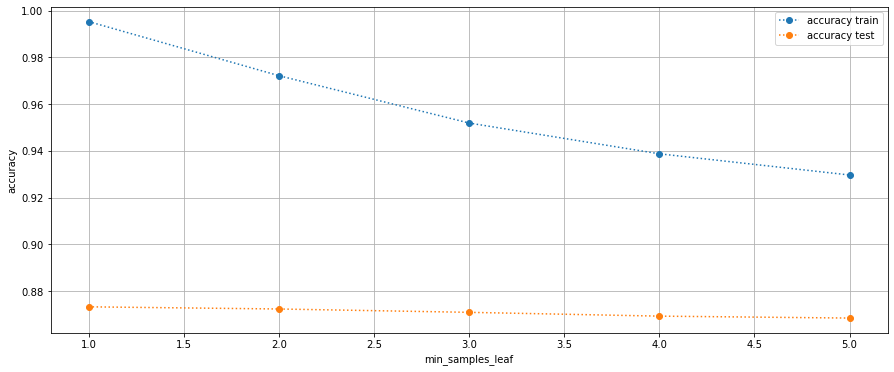

In [122]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(min_samples_leaf,avg_train_scoreNum, 'o:', label='accuracy train')
ax.plot(min_samples_leaf,avg_test_scoreNum, 'o:', label='accuracy test')
ax.set_ylabel('accuracy')
ax.set_xlabel('min_samples_leaf')
ax.grid()
ax.legend()

### Logistic Regressor

#### tuning del tol (default = 100)

In [123]:
tol = [0.000001, 0.00001, 0.0001, 0.001, 0.01]

In [124]:
train_scoreNum, test_scoreNum = validation_curve(
                                LogisticRegression(),
                                X = X_train_r30_ov, y = y_train_r30_ov, 
                                param_name = 'tol', 
                                param_range = tol, cv = 3)

In [125]:
train_scoreNum

array([[0.64812621, 0.64890129, 0.64901346],
       [0.64812621, 0.64890129, 0.64901346],
       [0.64812621, 0.64890129, 0.64901346],
       [0.64812621, 0.64890129, 0.64901346],
       [0.64812621, 0.64890129, 0.64901346]])

In [126]:
test_scoreNum

array([[0.64650104, 0.64863031, 0.64842352],
       [0.64650104, 0.64863031, 0.64842352],
       [0.64650104, 0.64863031, 0.64842352],
       [0.64650104, 0.64863031, 0.64842352],
       [0.64650104, 0.64863031, 0.64842352]])

In [127]:
avg_train_scoreNum = np.average(train_scoreNum, axis=1)

In [128]:
avg_test_scoreNum = np.average(test_scoreNum, axis=1)

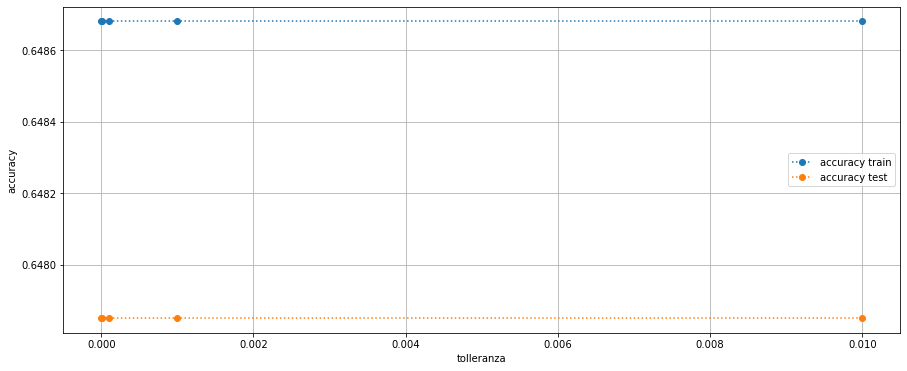

In [129]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(tol,avg_train_scoreNum, 'o:', label='accuracy train')
ax.plot(tol,avg_test_scoreNum, 'o:', label='accuracy test')
ax.set_ylabel('accuracy')
ax.set_xlabel('tolleranza')
ax.grid()
ax.legend()

### Logistic Regressor

#### tuning del C (default = 100)

In [130]:
C = [0.8, 0.9, 1.0, 1.1, 1.2, 1.5, 2.0]

In [131]:
train_scoreNum, test_scoreNum = validation_curve(
                                LogisticRegression(),
                                X = X_train_r30_ov, y = y_train_r30_ov, 
                                param_name = 'C', 
                                param_range = C, cv = 3)

In [132]:
train_scoreNum

array([[0.64812621, 0.64889544, 0.64902808],
       [0.64812036, 0.64889544, 0.64902516],
       [0.64812621, 0.64890129, 0.64901346],
       [0.64818471, 0.64892761, 0.64899884],
       [0.64817008, 0.64889837, 0.64899591],
       [0.64816716, 0.64891006, 0.64902808],
       [0.64810574, 0.64887204, 0.64902808]])

In [133]:
test_scoreNum

array([[0.6463665 , 0.64863031, 0.64845276],
       [0.6463899 , 0.64862446, 0.64844691],
       [0.64650104, 0.64863031, 0.64842352],
       [0.64643085, 0.64865956, 0.64846446],
       [0.6464484 , 0.64864786, 0.64847616],
       [0.64645425, 0.64865956, 0.64844691],
       [0.64641915, 0.64865956, 0.64840597]])

In [134]:
avg_train_scoreNum = np.average(train_scoreNum, axis=1)

In [135]:
avg_test_scoreNum = np.average(test_scoreNum, axis=1)

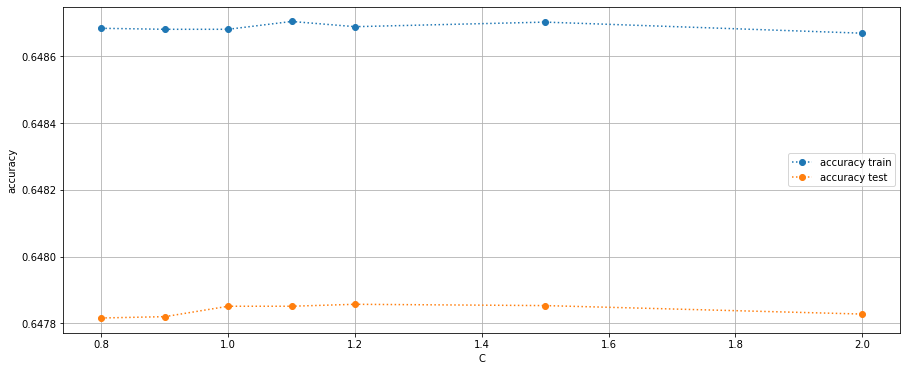

In [136]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(C,avg_train_scoreNum, 'o:', label='accuracy train')
ax.plot(C,avg_test_scoreNum, 'o:', label='accuracy test')
ax.set_ylabel('accuracy')
ax.set_xlabel('C')
ax.grid()
ax.legend()

# Predizioni finali sul test ( modello scelto logistic regressor)
applico il modello scelto al test set

In [137]:
X_test_r30  # il test set mai visto dal modello, che bisogna però scalare

,gender,age,icd_D_blood,icd_D_health_status,icd_D_pregnancy,icd_D_abnormal,icd_D_chromosomal,icd_D_infectious_parasitic,icd_D_musculoskeletal,icd_D_nervous_system,...,ethn__BLACK/AFRICAN AMERICAN,ethn__HISPANIC/LATINO,ethn__OTHER,ethn__UNKNOWN,ethn__WHITE,ins__Medicare,ins__Other,maritalS__MARRIED,maritalS__SINGLE,maritalS__WIDOWED
465869,0,46,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,1,0
416293,0,48,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
98968,0,60,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
254219,0,0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,1,0
4251,0,43,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,1,84,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,1,0
365838,1,59,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,1,0,0,0,0
131932,1,57,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,1,0,0,1,0
146867,1,33,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,1,0


In [138]:
y_test_r30  # questi sono i dati su cui verrà calcolato l'accuracy score finale

465869    0
416293    0
98968     0
254219    0
4251      0
         ..
259178    0
365838    1
131932    0
146867    1
121958    0
Name: riad 30d, Length: 156333, dtype: int64

In [139]:
X_test_r30_scaled = scaler.transform(X_test_r30)  # fitting and transforming training set
X_test_r30_scaled

array([[-0.96512577, -0.22152246, -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958],
       [-0.96512577, -0.1450444 ,  0.96630854, ..., -0.87579316,
        -0.83029661, -0.32124958],
       [-0.96512577,  0.31382392, -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       ...,
       [ 1.03613439,  0.19910684, -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958],
       [ 1.03613439, -0.71862981, -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958],
       [ 1.03613439,  1.15508251,  3.93293702, ..., -0.87579316,
        -0.83029661,  3.11284458]])

In [140]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_r30_ov, y_train_r30_ov)

LogisticRegression(random_state=42)

In [141]:
final_pred_lr = lr.predict(X_test_r30_scaled)
final_pred_lr

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [142]:
acc_lr = accuracy_score(y_test_r30, final_pred_lr)
acc_lr

0.5977560719745671

In [143]:
cm_lr_final = confusion_matrix(y_test_r30, final_pred_lr)
ps_lr_final = precision_score(y_test_r30, final_pred_lr)
rs_lr_final = recall_score(y_test_r30, final_pred_lr)
f1_lr_final = f1_score(y_test_r30, final_pred_lr)

In [144]:
perf_lr_final = {
                   'Metric': ['precision','recall','f1'],
                   'final': [ps_lr_final, rs_lr_final, f1_lr_final]
                 }

In [145]:
table_lr_final = pd.DataFrame(perf_lr_final, columns = ['Metric', 'final'])
table_lr_final.style.set_table_attributes("style='display:inline'").set_caption('LOGISTIC REGRESSOR FINAL PERFORMANCES')

,Metric,final
0,precision,0.273248
1,recall,0.719590
2,f1,0.396089


In [146]:
print("{} veri positivi".format(cm_lr_final[1,1]))
print("{} veri negativi".format(cm_lr_final[0,0]))
print("{} falsi positivi".format(cm_lr_final[0,1]))
print("{} falsi negativi".format(cm_lr_final[1,0]))

20622 veri positivi
72827 veri negativi
54848 falsi positivi
8036 falsi negativi


ancora una volta tra i vari modelli il logistic regressor tende a massimizzare la recall anche se in questo caso è più difficile definire se è preferibile massimizzare la recall e accontentarci su precision e accuracy 